In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import requests
from io import StringIO as sio

import baltic as bt


Tree height: 29.430115
Tree length: 451.887106
strictly bifurcating tree
annotations present

Numbers of objects in tree: 903 (451 nodes and 452 leaves)

1982.7228900152938 Root
subtree resulting from ancestor>Y switch, traversing within Y
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V
subtree resulting from Y>V switch, traversing within V


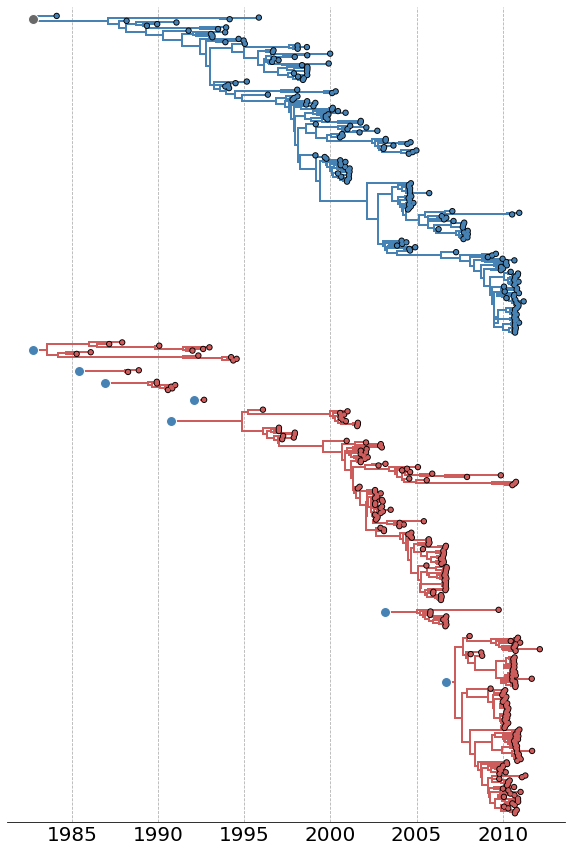

In [2]:
address='https://raw.githubusercontent.com/evogytis/fluB/master/data/mcc%20trees/InfB_NPt_ALLs1.mcc.tre' ## address of example tree
fetch_tree = requests.get(address) ## fetch tree
treeFile=sio(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile,tip_regex='_([0-9\-]+)$') ## treeFile here can alternatively be a path to a local file
ll.treeStats() ## report stats about tree

traitName='PB1' ## trait which will be used to disassemble the tree
branchWidth=2

print(ll.root.absoluteTime,ll.root.parent.index)
tree_strings={'Y':[],'V':[],'ancestor':[]}
subtype_trees={'Y':[],'V':[],'ancestor':[]}

for l in ll.Objects: ## iterate over branches
    k=l ## branch
    kp=l.parent ## branch's parent
    
    ## get current node's and its parent's trait states
    kloc=k.traits[traitName] ## get branch trait value
    if traitName in k.parent.traits: ## if parent has trait
        kploc=kp.traits[traitName] ## get parental trait value
        kpc=kploc
    else: ## parent does not have trait value, must be at root
        kploc='ancestor'
        kpc='ancestor'

    kc=kloc ## kc is branch trait value, kpc is branch parent trait value
    
    ## if states do not match
    if kc!=kpc:
        traverse_condition=lambda w:w.traits[traitName]==kc ## only traverse tree for as long as branches are in the branch state
        print('subtree resulting from %s>%s switch, traversing within %s'%(kpc,kc,kc))
        subtree=ll.subtree(k,traverse_condition=traverse_condition) ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state
        
        if subtree: ## if the conditional subtree traversal failed because no tips were encountered None is returned
            subtree.traverse_tree() ## traverse subtree
            subtree.sortBranches() ## sort branches
            tree_strings[kc].append(subtree.toString()) ## remember subtree string, subtree object itself
            subtype_trees[kc].append((kpc,subtree)) ## add parental state and subtree to list

fig = plt.figure(figsize=(10, 15),facecolor='w') ## create figure
gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(gs[0],facecolor='w') ## create axes

tipSize=20
cumulative_y=0

x_attr=lambda k: k.absoluteTime
c_func=lambda k: 'indianred' if k.traits[traitName]=='V' else 'steelblue'

for subtype in ['V','Y']: ## iterate over trait values
    for t,tr in enumerate(sorted(subtype_trees[subtype],key=lambda x:(-x[1].root.absoluteTime,len(x[1].Objects)))): ## iterate over extracted subtrees sorted according to their root height and their size
        origin,loc_tree=tr ## get origin of subtree, subtree itself
        
        y_attr=lambda k: k.y+cumulative_y ## subtree y values will be offset
        
        loc_tree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,colour=c_func) ## plot subtree
        loc_tree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=tipSize,colour=c_func,zorder=100) ## plot tip points
        
        oriC='dimgrey' if origin=='ancestor' else c_func(loc_tree.root.parent) ## origin of subtree
        
        oriX=loc_tree.root.absoluteTime-loc_tree.root.length
        oriY=loc_tree.root.y+cumulative_y
        
        ax.scatter(oriX,oriY,100,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        cumulative_y+=loc_tree.ySpan+5 ## increment y displacement
        
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

[ax.spines[loc].set_visible(False) for loc in ['top','right','left']]

ax.tick_params(axis='x',size=0,labelsize=20) ## no x axis ticks or labels
ax.tick_params(axis='y',size=0)

ax.grid(axis='x',ls='--')

ax.set_yticklabels([])
ax.set_ylim(-5,cumulative_y)

plt.show()

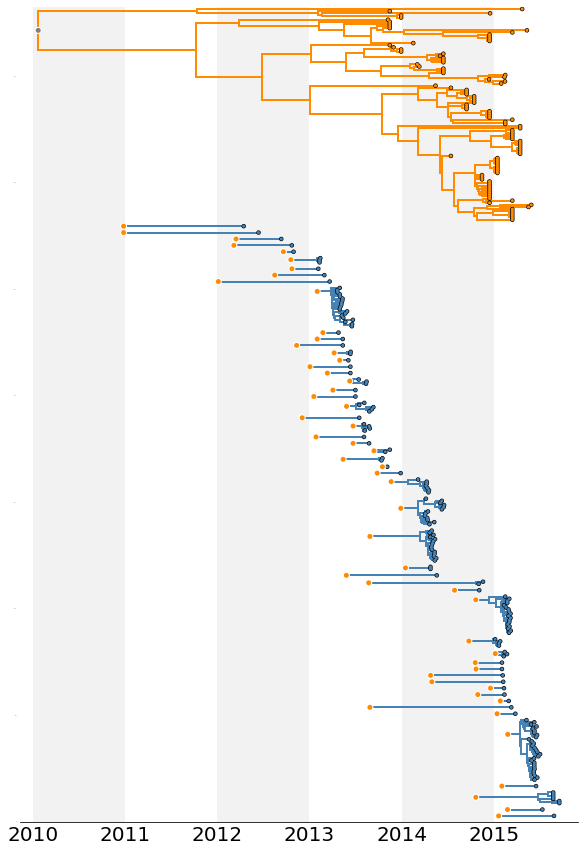

In [3]:
address='https://github.com/sdwfrost/mers-treedater/raw/master/MERS_274_sCoal.combinedTyped.mcc.tree' ## where the tree we'll use lives

fetch_tree = requests.get(address) ## fetch tree
treeFile=sio(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile) ## treeFile here can alternatively be a path to a local file

fig = plt.figure(figsize=(10, 15),facecolor='w') ## create figure
gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(gs[0],facecolor='w') ## create axes

host_is_human=lambda k: k.traits['type']=='h' ## return true if branch is in humans
host_colour=lambda k: 'steelblue' if host_is_human(k) else 'darkorange' ## colour blue if human and orange otherwise

same_host=lambda k: 'type' in k.parent.traits and k.parent.traits['type']==k.traits['type'] ## branch is in same host as parent branch

subtree_stack={} ## will store trees in lists tied to each (new) trait value

for k in sorted(ll.getBranches(lambda w: same_host(w)==False),key=lambda q: q.height): ## get branches where host changed, iterate from youngest to oldest
    introduced_into=k.traits['type'] ## get new trait value
    if introduced_into not in subtree_stack: subtree_stack[introduced_into]=[] ## start a list if new trait value not seen before
        
    trait_subtree=ll.subtree(k,traverse_condition=same_host,stem=True) ## traverse subtree staying inside new host
    subtree_stack[introduced_into].append(trait_subtree) ## add subtree to appropriate trait value bin
    
cumulative_y_offset=0
y_gap=2

for trait in sorted(subtree_stack,key=lambda w: -subtree_stack[w][0].root.absoluteTime): ## iterate over trait values, starting with whichever trait has the earlier subtree
    for subtree in sorted(subtree_stack[trait],key=lambda w: -w.root.absoluteTime): ## sort the subtrees within a bin by their root date
        subtree.drawTree() ## compute new coordinates for all branches
        x_attr=lambda k: k.absoluteTime ## will be plotting in absolute time
        y_attr=lambda k: cumulative_y_offset+k.y+y_gap ## y position should be offset by the gap between subtrees and cumulative offset from all subtrees plotted so far
        
        subtree.plotTree(ax,x_attr=x_attr,y_attr=y_attr,width=2,colour=host_colour) ## plot subtree
        subtree.plotPoints(ax,x_attr=x_attr,y_attr=y_attr,size=10,colour=host_colour) ## plot tip points
        
        origin_colour=host_colour(subtree.root.parent) if 'type' in subtree.root.parent.traits else 'grey' ## assign colour - origin if available, grey if root (i.e. no previous state available)
        
        s=25
        ax.scatter(x_attr(subtree.root)-subtree.root.length,y_attr(subtree.root),s=s,facecolor=origin_colour,edgecolor='none',zorder=10) ## put a dot at the root of each subtree
        ax.scatter(x_attr(subtree.root)-subtree.root.length,y_attr(subtree.root),s=s*2,facecolor='w',edgecolor='none',zorder=9) ## put a dot at the root of each subtree
        
        cumulative_y_offset+=y_gap+subtree.ySpan ## offset next trees by whatever amount of y axis space this subtree occupies + gap


[ax.axvspan(t,t+1,facecolor='k',edgecolor='none',alpha=0.05,zorder=0) for t in range(2010,2018) if t%2==0]
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']] ## remove all figure spines except bottom

ax.tick_params(axis='x',size=0,labelsize=20) ## no x axis ticks or labels
ax.tick_params(axis='y',size=0,labelsize=0) ## no y axis ticks or labels

ax.set_xlim(ll.root.absoluteTime-0.2,ll.mostRecent+0.2) ## limit x axis
ax.set_ylim(-0.5,cumulative_y_offset+0.5) ## limit y axis

plt.show()